# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

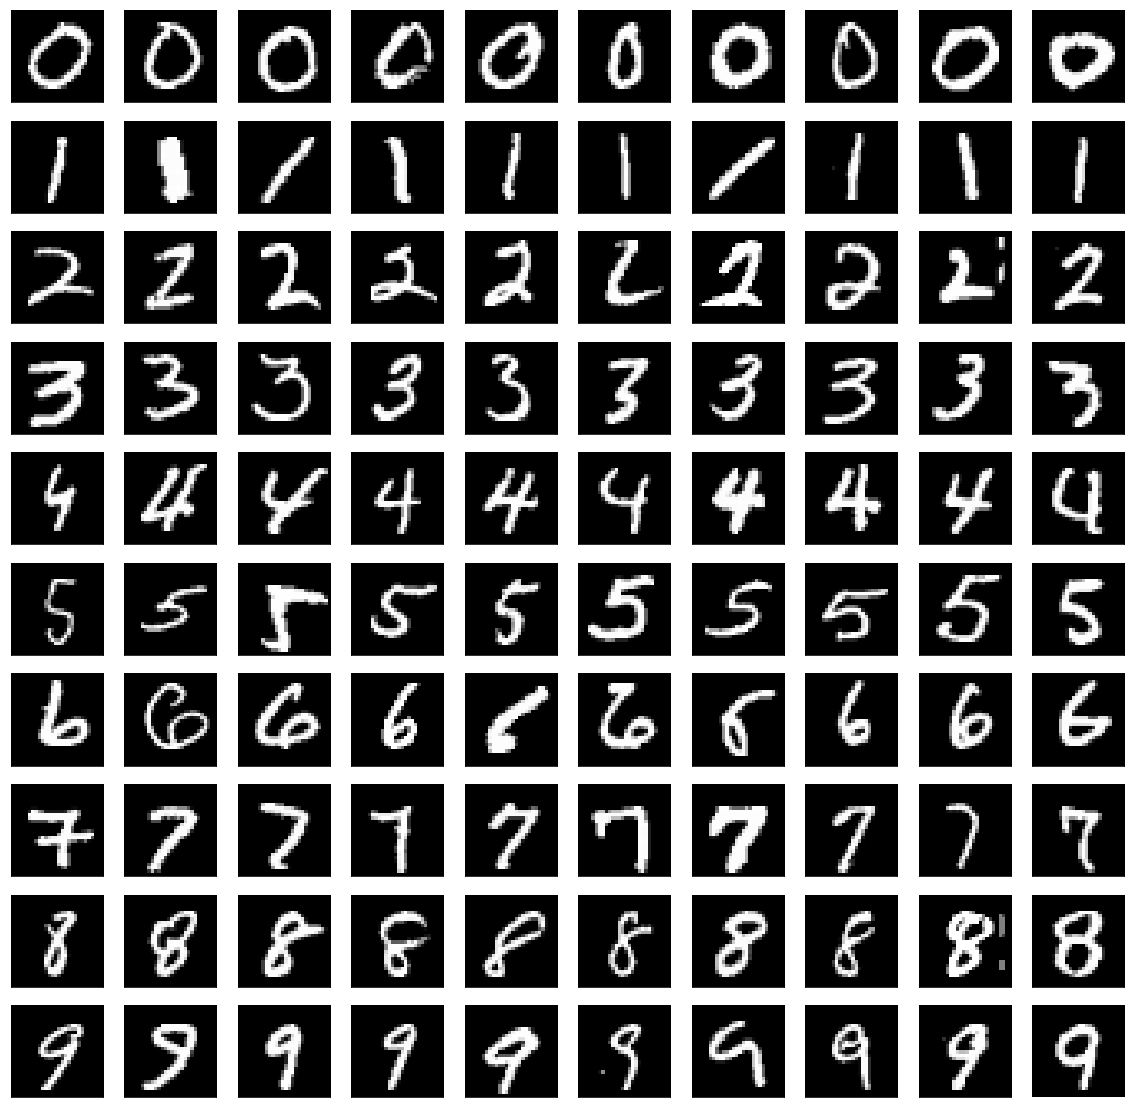

In [229]:
def P1(num_examples=10):
  
### STUDENT START ###

    # This structure will hold a list of indices such that ranges[0][]
    # Wlll contain all the indexes to element '0' 
    ranges = [
        [],[],[],[],[],[],[],[],[],[]
    ]
    # populate ranges and choose 10 random elements
    # from each row
    [ranges[int(val)].append(i) for i,val in enumerate( mnist.target )]
    indices = [(np.random.choice(ranges[x],size=num_examples,replace=False)) for x in range(0,10)]

    #Set image color map to grey to render 0=black to 1= white and degree of gray in between
    plt.rc("image",cmap="gray")
    fig, sp = plt.subplots(10,num_examples,)
    plt.axis('off')

    for x,lst in enumerate(indices):
        for y,index in enumerate(lst):
            sp[x][y].xaxis.set_visible(False)
            sp[x][y].yaxis.set_visible(False)
            sp[x][y].imshow(mnist.data[index].reshape(28,28))
        
    plt.show()    
### STUDENT END ###

P1(10)


(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [5]:
def P2(k_values):

### STUDENT START ###

    # Iterate through k_values.  Create a knn using the selected
    # number of neighbors.  Fit against mini_train data and run
    # against dev data.  print results
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = knn.fit(mini_train_data, mini_train_labels).score(dev_data, dev_labels)
        print( "KNN accuracy for k = {0:1d} : {1:1.3f}".format(k,score))
    print

    # for neighbors = 1, produce classification report
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data, mini_train_labels)
    predictions = knn.predict(dev_data)
    print(classification_report(dev_labels, predictions))
    
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

KNN accuracy for k = 1 : 0.888
KNN accuracy for k = 3 : 0.878
KNN accuracy for k = 5 : 0.869
KNN accuracy for k = 7 : 0.865
KNN accuracy for k = 9 : 0.863

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



ANSWER:
3 is the most difficult digit

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [6]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    # create structure to hold durations
    durations = []
    
    # iterate through training sizes
    for train_size in train_sizes:
        # create a random sample of training data
        indices = np.random.choice(range(0,len(train_data)), size=train_size, replace=False)
        # Create knn
        knn = KNeighborsClassifier(n_neighbors=1)
        # start timer
        start = time.time()
        # train model against training dat and score against dev data
        # for each seleced size
        score = knn.fit(train_data[indices], train_labels[indices]).score(dev_data, dev_labels)
        # end clock
        end = time.time()
        # record score and duration
        accuracies.append(score)
        durations.append(end - start)
        
    for i in range (0,len(train_sizes)):
        print("Training size: {0:} Accuracy: {1:1.4f} Duration: {2:1.4f}".format(train_sizes[i],accuracies[i],durations[i]))   
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Training size: 100 Accuracy: 0.7030 Duration: 0.1104
Training size: 200 Accuracy: 0.7760 Duration: 0.2337
Training size: 400 Accuracy: 0.8480 Duration: 0.4637
Training size: 800 Accuracy: 0.8750 Duration: 0.9190
Training size: 1600 Accuracy: 0.9080 Duration: 1.9011
Training size: 3200 Accuracy: 0.9230 Duration: 3.9299
Training size: 6400 Accuracy: 0.9330 Duration: 8.4036
Training size: 12800 Accuracy: 0.9590 Duration: 16.6322
Training size: 25000 Accuracy: 0.9580 Duration: 34.1522


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

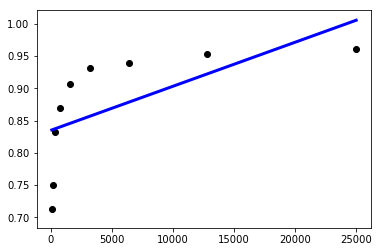

[ 1.24471491]


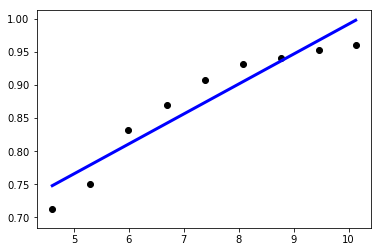

[ 2715.03922171]


In [233]:
def P4():

### STUDENT START ###
    # sizes and accuracies from problem 3
    train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
    accuracies = [0.7130,0.7510,0.8320,0.8700,0.9070,0.9320,0.9400,0.9530,0.9610]

    # Create an array of arries, each of size 1 containing a value
    # form train_sizes
    train_sizes_array = [[train_sizes[i]] for i in range(0,len(train_sizes))]
    
    # create regression and fit
    lr = LinearRegression()  
    lr.fit(train_sizes_array,accuracies)
    
    #plot results
    plt.scatter(train_sizes_array, accuracies,  color='black')
    plt.plot(train_sizes_array, lr.predict(train_sizes_array), color='blue',linewidth=3)

 #   plt.xticks(())
 #   plt.yticks(())

    plt.show()
    
    print lr.predict(60000)
    
    # Apply log transformation to data
    train_size_array_log = [[np.log(train_sizes[i])] for i in range(0,len(train_sizes))]
    # create and fit regression
    lr = LinearRegression()  
    lr.fit(train_size_array_log,accuracies)
    
    # plot results
    plt.scatter(train_size_array_log, accuracies,  color='black')
    plt.plot(train_size_array_log, lr.predict(tsvl), color='blue',linewidth=3)

    plt.show()
    print lr.predict(60000)
    

    
### STUDENT END ###

P4()

ANSWER:
For n=60000 the regression predicts 1.24471491.  But the data appears asympytotic to 1.  The regression apears to fit much better once a log transformation is applied to the data.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion matrix:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


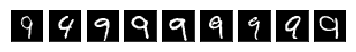

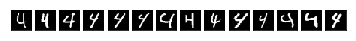

In [8]:
def P5():

### STUDENT START ###
    # Create knn with 1 neighbor
    knn = KNeighborsClassifier(n_neighbors=1)
    # Train against traiing data
    knn.fit(mini_train_data, mini_train_labels)
    expected = dev_labels
    predicted = knn.predict(dev_data)
    #create confusion matrix using expected and predicted values
    cm = confusion_matrix(expected, predicted)
    print("Confusion matrix:\n%s" % cm)

    # crete lists of indices of 4s that were confused for 9s
    # and 9s that were confused for 4s
    cl_4_9,cl_9_4 = [],[]
    for i,val in enumerate(predicted):
        if val == 4 and expected[i] == 9:
            cl_4_9.append(i)
        if val == 9 and expected[i] == 4:
            cl_9_4.append(i)
 
            
    # Set image color map to grey to render 
    # 0=black to 1= white and degree of gray in between
    plt.rc("image",cmap="gray")
    fig, sp = plt.subplots(1,len(cl_4_9))

    # render 9s
    for y in range(0,len(cl_4_9)):
            sp[y].xaxis.set_visible(False)
            sp[y].yaxis.set_visible(False)
            sp[y].imshow(dev_data[cl_4_9[y]].reshape(28,28))
    plt.show()  
    
    # render 4s
    fig, sp = plt.subplots(1,len(cl_9_4))
    for y in range(0,len(cl_9_4)):
        sp[y].xaxis.set_visible(False)
        sp[y].yaxis.set_visible(False)
        sp[y].imshow(dev_data[cl_9_4[y]].reshape(28,28))
    plt.show() 
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

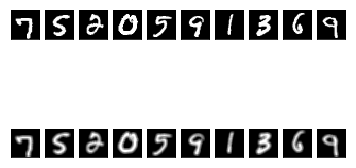


Training data: clear Dev data: clear KNN accuracy: 0.888
Training data: blur Dev data: clear KNN accuracy: 0.911
Training data: clear Dev data: blur KNN accuracy: 0.867
Training data: blur Dev data: blur KNN accuracy: 0.903


In [240]:
def P6():
    
### STUDENT START ###

    # max dimension of rendered character (28x28)
    max_d = 28
    # blank copies of training and dev data
    mini_train_data_copy = np.zeros(mini_train_data.shape)
    dev_data_copy = np.zeros(dev_data.shape)
       
    # a matrix of relative positions.  for each [0,0], we can
    # calculate the neighbors using this structure
    pos_mat = np.array([ 
                            [-1,-1],[0,-1],[1,-1],
                            [-1,0],        [1,0],
                            [-1,1],[0,1]  ,[1,1] 
                        ])
    # Creates a blured copy of m1 into m2
    def blur(m1,m2):  
        for x1 in range(max_d):
            for y1 in range(max_d):
                # sum and count used to determine average
                sum, count = 0,0
                # iterate through list of coordinates
                for pm in (pos_mat + [x1,y1]):
                    # examine each x and y
                    x2,y2 = pm[0],pm[1]
                    # if the x and y coords are within the m1 space
                    # increment sum and count.
                    # disguard offscreen pixels
                    if(x2 >= 0 ) & (x2 <= 27) & (y2 >= 0) & (y2 <= 27):
                        sum += m1[x2][y2]
                        count = count+1 
                # calculate average and assign to blank m2 matrix
                m2[x1][y1] = sum/count
    
    # blur training data and dev data copies
    for i in range(1000):
        blur(mini_train_data[i].reshape(28,28),mini_train_data_copy[i].reshape(28,28))        
        blur(dev_data[i].reshape(28,28),dev_data_copy[i].reshape(28,28))        
    
    # plot a sample of blured and regular characters
    fig, sp = plt.subplots(2,10)
    indices = np.random.choice(1000,10)

    for y,index in enumerate(indices):
        sp[0,y].xaxis.set_visible(False)
        sp[0,y].yaxis.set_visible(False)
        sp[1,y].xaxis.set_visible(False)
        sp[1,y].yaxis.set_visible(False)
        sp[0,y].imshow(mini_train_data[index].reshape(28,28))
        sp[1,y].imshow(mini_train_data_copy[index].reshape(28,28))
    plt.show() 

    def knn_test(train_data, dev_data,t_label, d_label):
        knn = KNeighborsClassifier(n_neighbors=1)
        score = knn.fit(train_data, mini_train_labels).score(dev_data, dev_labels)
        print( "Training data: "+t_label+" Dev data: "+d_label+" KNN accuracy: {0:1.3f}".format(score))
    print
        
    # clear training clear dev - baseline
    knn_test(mini_train_data,dev_data,"clear","clear")
    # blured training clear dev data
    knn_test(mini_train_data_copy,dev_data,"blur","clear")
    # clear training blured dev data
    knn_test(mini_train_data,dev_data_copy,"clear","blur")
    # blur training blured dev data
    knn_test(mini_train_data_copy,dev_data_copy,"blur","blur")
    
  
    
### STUDENT END ###

P6()


(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [82]:
# Global declerations used in the next few cells

# Applies function f to 2d array a
def pre_process_data(a,f):
    ret = np.zeros(a.shape)
    for x in range(a.shape[0]):
        for y in range(a.shape[1]):
            ret[x,y] = f(a[x,y])
    return ret;

# function used to turn real data into binary numbers
# based on value with respect to 0.5
def binarize(x):
    if x >= 0.5:
        return(1)
    else:
        return(0)

# creates 3 partitions of numbers 0,1,2
def trinarize(x):
    if (x >= 0 ) & (x < 1.0/3.0):
        return(0)
    elif (x >= 1.0/3.0) and (x < 2.0/3.0):
        return(1)
    else:
        return(2)
           

Binomial: 0.8150 Multinomial: 0.8030


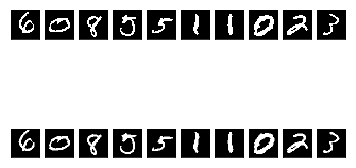

{0.0: 680273, 1.0: 103727}
{0.0: 668141, 1.0: 25501, 2.0: 90358}


In [83]:
def P7():

### STUDENT START ###
    
    # create binarized coppies of training and dev data
    mini_train_data_bin = pre_process_data(mini_train_data,binarize)
    dev_data_bin = pre_process_data(dev_data,binarize)

    # create trinarized (0,1,2) copies of train and dev data
    mini_train_data_mult = pre_process_data(mini_train_data,trinarize)
    dev_data_mult = pre_process_data(dev_data,trinarize)
          
    # crete naieve Bays classifier.  fit against binary training data
    # and score against binary dev data
    bnb = BernoulliNB()
    bin_score = bnb.fit(mini_train_data_bin, mini_train_labels).score(dev_data_bin, dev_labels)

    # create multinomial Bayes classifier.  Fit against trinarized training
    # data and score against trinarized dev data
    mnb = MultinomialNB()
    mult_score = mnb.fit(mini_train_data_mult, mini_train_labels).score(dev_data_mult, dev_labels)
  
    #print results
    print("Binomial: {0:1.4f} Multinomial: {1:1.4f}".format(bin_score,mult_score))

    # render random sample of binary and trinary figuures
    fig, sp = plt.subplots(2,10)
    indices = np.random.choice(1000,10)

    for y,index in enumerate(indices):
        sp[0,y].xaxis.set_visible(False)
        sp[0,y].yaxis.set_visible(False)  
        sp[1,y].xaxis.set_visible(False)
        sp[1,y].yaxis.set_visible(False)
        sp[0,y].imshow(dev_data_bin[index].reshape(28,28))
        sp[1,y].imshow(dev_data_mult[index].reshape(28,28))
    plt.show() 
    
        
    u1, c1 = np.unique(dev_data_bin, return_counts=True)
    u2, c2 = np.unique(dev_data_mult, return_counts=True)
    print dict(zip(u1, c1))
    print dict(zip(u2, c2))
### STUDENT END ###

P7()

ANSWER:
Binomial: 0.8150 Multinomial: 0.8030.  The binomial is slightly more accurate.  There was not a lot of information added by trinarizing the data.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [241]:
def P8(alphas):

### STUDENT START ###
    # create binarized coppies of traininf and dev data
    mini_train_data_bin = pre_process_data(mini_train_data,binarize)
    dev_data_bin = pre_process_data(dev_data,binarize)
    
    # create Bernoulli Naieve Bayes classifier
    bnb = BernoulliNB()
    
    # These are the default params for the creation of bnb
    # we don't use this other than to see that alphas are params
    # for the object
    params = {'binarize': 0.0, 'alpha': alphas, 'fit_prior': True, 'class_prior': None}
   
    # create the gridsearch CV to rank alpha values during fitting
    clf = GridSearchCV(bnb,alphas)
    # fit against training data
    clf.fit(mini_train_data_bin, mini_train_labels)
    
    # report best alpha and classification report
    print 'Best alpha', clf.best_params_
    actual, predicted = dev_labels, clf.predict(dev_data_bin)
    print(classification_report(actual, predicted))
    
    # repeat above for alpha=0
    bnb = BernoulliNB(alpha=0) 
    bnb.fit(mini_train_data_bin, mini_train_labels)
    predictions = bnb.predict(dev_data_bin)
    print(classification_report(dev_labels, predictions))
    


### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

Best alpha {'alpha': 0.01}
             precision    recall  f1-score   support

        0.0       0.92      0.97      0.95        99
        1.0       0.88      0.92      0.90       105
        2.0       0.83      0.79      0.81       102
        3.0       0.62      0.76      0.68        86
        4.0       0.90      0.78      0.84       104
        5.0       0.78      0.68      0.73        91
        6.0       0.89      0.90      0.89        98
        7.0       0.92      0.79      0.85       113
        8.0       0.74      0.75      0.75        96
        9.0       0.72      0.82      0.77       106

avg / total       0.82      0.82      0.82      1000

             precision    recall  f1-score   support

        0.0       0.10      1.00      0.18        99
        1.0       0.00      0.00      0.00       105
        2.0       0.00      0.00      0.00       102
        3.0       0.00      0.00      0.00        86
        4.0       0.00      0.00      0.00       104
        5.0    

In [86]:
#print bnb.best_params_

ANSWER: The best alpha is 0.01 which yields an overall average precisio of .82  For alpha = 0, mostly no characters are recognized.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [245]:
def P9():

### STUDENT START ###

    # create binarized coppies of traininf and dev data
    mini_train_data_bin = pre_process_data(mini_train_data,binarize)
    dev_data_bin = pre_process_data(dev_data,binarize)
    
    # create classifier and train against training data
    # create predictions using de data
    gnb = GaussianNB()
    gnb.fit(mini_train_data_bin, mini_train_labels)
    predictions = gnb.predict(dev_data_bin)
    print(classification_report(dev_labels, predictions))
    
    # Run again but change standard deviation to a common value
    # to smooth out over-weighting of black values
    gnb = GaussianNB()
    gnb.fit(mini_train_data_bin, mini_train_labels)
    predictions = gnb.predict(dev_data_bin)
    gnb.sigma_[:] = gnb.sigma_.mean()
    predictions = gnb.predict(dev_data_bin)
    print(classification_report(dev_labels, predictions))
  

### STUDENT END ###

gnb = P9()

             precision    recall  f1-score   support

        0.0       0.87      0.89      0.88        99
        1.0       0.86      0.90      0.88       105
        2.0       0.65      0.36      0.47       102
        3.0       0.46      0.42      0.44        86
        4.0       0.83      0.29      0.43       104
        5.0       0.53      0.31      0.39        91
        6.0       0.71      0.90      0.79        98
        7.0       0.76      0.74      0.75       113
        8.0       0.39      0.65      0.48        96
        9.0       0.53      0.84      0.65       106

avg / total       0.66      0.64      0.62      1000

             precision    recall  f1-score   support

        0.0       0.91      0.97      0.94        99
        1.0       0.70      0.95      0.81       105
        2.0       0.87      0.71      0.78       102
        3.0       0.61      0.72      0.66        86
        4.0       0.85      0.83      0.84       104
        5.0       0.81      0.64      0.71

ANSWER: These characters are dominated by zeros, making the mean and sigma values too minute to develop a useful normal distribution.  Normalizing sigma smoothed out the differences.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

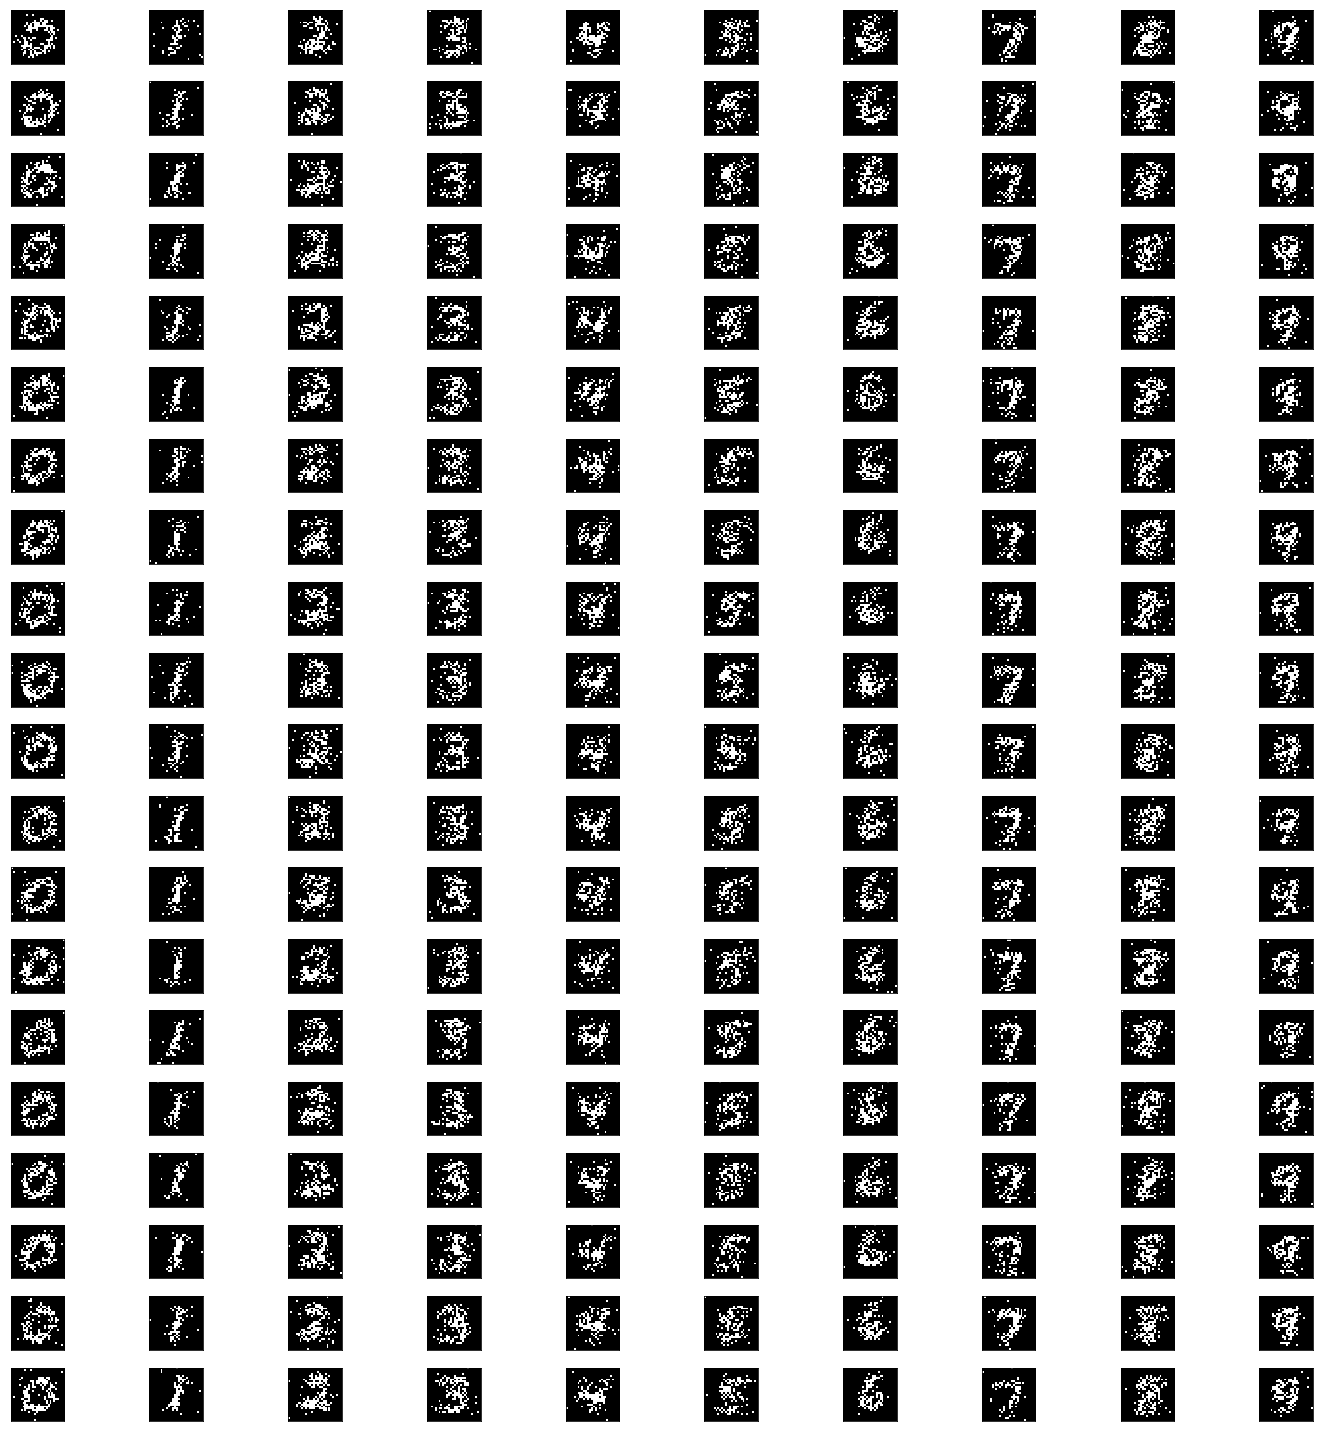

In [171]:
def P10(num_examples):

    # 10 columns
    cols = 10
    
    #utility method.  Takes the log probabilities of the classifier for a digit.
    # applies randomness to values to simulate a random sampeling of the set.
    def make_digit(model,digit):
        return np.exp(model.feature_log_prob_)[digit] > np.random.rand(784)
 
    # binarize training dat
    mini_train_data_bin = pre_process_data(mini_train_data,binarize) 
    
    # create classifier.  fit against training data 
    bnb = BernoulliNB()
    bnb.fit(mini_train_data_bin, mini_train_labels)
    
    # create graphic
    fig, sp = plt.subplots(nrows = num_examples,
                           ncols = cols,
                           figsize=(20,20))
    # render characters.  Note call to make_digit 
    for x in range(num_examples):
        for y in range(cols):
            sp[x,y].xaxis.set_visible(False)
            sp[x,y].yaxis.set_visible(False)  
            sp[x,y].imshow(make_digit(bnb,y).reshape(28,28))
    fig.tight_layout()
    plt.show() 

### STUDENT END ###

P10(20)

ANSWER:

The generted digits are fuzzier than the training digits.  This is dur to the random noise added to the training digits.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [225]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    #Train a BernoulliNB model with a reasonable alpha value.
    mini_train_data_bin = pre_process_data(mini_train_data,binarize)
    bnb = BernoulliNB(alpha=0.01)
    bnb.fit(mini_train_data_bin, mini_train_labels)
    posterior_probs = bnb.predict_proba(dev_data)
    predictions = bnb.predict(dev_data)
    
    # return the bucket that value val should be stored in
    def get_bucket(buckets,val):
        buckets = np.array(buckets)
        ret = -1
        for i, bucket in enumerate(buckets):
            if val <= bucket:
                pass         
        if ret <= 0:
            return buckets.min()
        else:
            return buckets[i]
    
    # For each posterior bucket (think of a bin in a histogram), 
    # you want to estimate the classifier's accuracy.

    # So for each prediction, find the bucket the maximum posterior 
    # belongs to and update the "correct" and "total" counters.
    
    
    #Iterate through predictions
    for i,prediction in enumerate(predictions):
        # Find the index of the bucket that matches the probability
        index = buckets.index(get_bucket(buckets,posterior_probs[i, prediction]))
        # Increment total
        total[index] += 1
        # adjust correct list
        if prediction == dev_labels[i]:
                correct[index] += 1
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)


p(pred) <= 0.5000000000000    total = 1000    accuracy = 0.000
p(pred) <= 0.9000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9990000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9999900000000    total =   0    accuracy = 0.000
p(pred) <= 0.9999999000000    total =   0    accuracy = 0.000
p(pred) <= 0.9999999990000    total =   0    accuracy = 0.000
p(pred) <= 0.9999999999900    total =   0    accuracy = 0.000
p(pred) <= 0.9999999999999    total =   0    accuracy = 0.000
p(pred) <= 1.0000000000000    total =   0    accuracy = 0.000


/Users/johnvtabbone/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ANSWER:

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [253]:
#def P12():

### STUDENT END ###

#P12()